In [1]:
%pylab inline
import matplotlib.pyplot as plt

import tensorflow as tf
#from tensorflow.models.rnn import rnn, rnn_cell
import numpy as np
import numpy.random as rng

import time

import pandas.io.data as web
from pykalman import KalmanFilter
import numpy as np
import pandas as pd
import seaborn

Populating the interactive namespace from numpy and matplotlib


In [2]:

def get_prices(symbol):
    start, end = '2007-05-02', '2016-04-11'
    data = web.DataReader(symbol, 'yahoo', start, end)
    data=pd.DataFrame(data)
    prices=data['Adj Close']
    prices=prices.astype(float)
    return prices

def get_returns(prices):
        return ((prices-prices.shift(-1))/prices)[:-1]
    
def get_data(list):
    l = []
    for symbol in list:
        rets = get_returns(get_prices(symbol))
        l.append(rets)
    return np.array(l).T
        
rets = get_data(['C', 'GS'])

In [3]:
def lstm_iterator(raw_data, batch_size, num_steps, data_size):
 
  raw_data = np.array(raw_data, dtype=np.float32)

  data_len = len(raw_data)
  batch_len = data_len // batch_size
  data = np.zeros([batch_size, batch_len, data_size], dtype=np.float32)
  for i in range(batch_size):
    data[i] = raw_data[batch_len * i:batch_len * (i + 1),:]

  epoch_size = (batch_len - 1) // num_steps

  if epoch_size == 0:
    raise ValueError("epoch_size == 0, decrease batch_size or num_steps")

  for i in range(epoch_size):
    x = data[:, i*num_steps:(i+1)*num_steps]
    y = data[:, i*num_steps+1:(i+1)*num_steps+1]
    yield (x, y)

In [4]:
def run_epoch(session, m, data, eval_op, verbose=False, get_out=False):
  """Runs the model on the given data."""
  epoch_size = ((len(data) // m.batch_size) - 1) // m.num_steps
  start_time = time.time()
  costs = 0.0
  iters = 0
  state = m.initial_state.eval()
  output = []
  inp = []
  targ = []
  for step, (x, y) in enumerate(lstm_iterator(data, m.batch_size, m.num_steps, m.data_size)):
    cost, state, _ = session.run([m.cost, m.final_state, eval_op],
                                 {m.input_data: x,
                                  m.targets: y,
                                  m.initial_state: state})
    costs += cost
    #print(cost)
    iters += m.num_steps
    if get_out: 
      output.append(_)
      inp.append(x)
      targ.append(y)
    
  if len(output) > 0: 
    return output, inp, targ

  ''' if verbose and step % (epoch_size // 10) == 10:
      print("%.3f perplexity: %.3f speed: %.0f wps" %
            (step * 1.0 / epoch_size, np.exp(costs / iters),
             iters * m.batch_size / (time.time() - start_time)))
  '''
  return np.exp(costs / iters)



In [5]:
class SmallConfig(object):
    """Small config."""
    init_scale = 1.1
    learning_rate = .60
    max_grad_norm = 5
    num_layers = 4
    num_steps = 25
    hidden_size = 200
    max_epoch = 4
    max_max_epoch = 13
    keep_prob = 1.0
    lr_decay = 0.9
    batch_size = 20
    #vocab_size = 10000
    
class TestConfig(object):
  """Tiny config, for testing."""
  init_scale = 0.1
  learning_rate = 1.0
  max_grad_norm = 1
  num_layers = 4
  num_steps = 25
  hidden_size = 20
  max_epoch = 1
  max_max_epoch = 1
  keep_prob = 1.0
  lr_decay = 0.5
  batch_size = 20
  #vocab_size = 10000
  #data_size= 2

def get_config(test=False):
    if test:
        return TestConfig()
    return SmallConfig()

In [6]:
class LSTMModel(object):

    def __init__(self, is_training, config):
        self.batch_size = batch_size = config.batch_size
        self.num_steps = num_steps = config.num_steps
        self.data_size = data_size = config.data_size
        size = config.hidden_size
        
        
        
        position_transform = tf.constant([[-1.,0.,1]])
        pb_number = 3
        
        # set PLACEHOLDERS
        self._input_data = tf.placeholder(tf.float32, [batch_size, num_steps, data_size])
        self._targets = tf.placeholder(tf.float32, [batch_size, num_steps, data_size])
        # set VARIABLES
        lstm_cell = tf.nn.rnn_cell.BasicLSTMCell(size, forget_bias=0.0)
        cell = tf.nn.rnn_cell.MultiRNNCell([lstm_cell] * config.num_layers)
        cell = tf.nn.rnn_cell.InputProjectionWrapper(cell,  size)
        cell = tf.nn.rnn_cell.OutputProjectionWrapper(cell, pb_number*data_size)
        if is_training and config.keep_prob < 1:
            cell = tf.nn.rnn_cell.DropoutWrapper(
                cell, output_keep_prob=config.keep_prob)
        
        # loop through timesteps and record output
        outputs = []
        self._initial_state = cell.zero_state(batch_size, tf.float32)
        state = self._initial_state
        with tf.variable_scope("RNN"):
            for time_step in range(num_steps):
                if time_step > 0: tf.get_variable_scope().reuse_variables()
                    
                (cell_output, state) = cell(tf.reshape(self._input_data[:, time_step,:], [-1, data_size]), state)
                outputs.append(cell_output)
        
        self._final_state = state    #shape: [20,160]
        
        #reshape to [batchsize*num_steps, 3*data_size]
        self._output = output = tf.reshape(tf.concat(1, outputs), [-1, data_size*pb_number])
        targets = tf.reshape(self._targets, [-1,data_size])
        
        
        
        pos_one_hot = {}
        t_dict = {}
        returns = []
        for i in range(data_size):
            relevant_output = output[:,i*pb_number:(i+1)*pb_number]
            sample = tf.argmax(relevant_output) #this should be SAMPLE
            pos_one_hot[i] = tf.one_hot(sample, depth= 3, on_value=-1.0, off_value=0.0)
            t_dict[i] = tf.matmul(tf.reshape(targets[:,i], [-1,1]) , position_transform)
            cross_entropy = tf.nn.softmax_cross_entropy_with_logits(output, pos_one_hot[i])
            
            returns.append( tf.mul(sample , t_dict[i])  )
        returns = tf.reduce_sum(tf.concat(1,returns), 1)
        total_return = tf.reduce_prod(returns+1)
        
        
        cross_entropy = tf.nn.softmax_cross_entropy_with_logits(output, tf.nn.softmax(target_menu))
        
        #pos_one_hot = tf.concat(1, [ v for v in pos_one_hot.values() ])
        self._cost = cost  =  total_return #* -100
        cost = cost*-1
        
        #vol = tf.(returns)
        #sharpe = total_return/vol
        
        
        
        
        
        '''
        self._output = output = tf.reshape(tf.concat(1, outputs), [-1, data_size*3]) # shape: [500, 3]=[??,data_size*3]
        self._final_state = state    #shape: [20,160]    =     [hidden size, ??]
        targets = tf.reshape(self._targets, [-1,data_size])
        
        outdict = {}
        tm_dict = {}
        xe_list = []
        for i in range(data_size):
            outdict[i] = output[:,i*3:(i+1)*3]
            tm_dict[i] = tf.matmul(tf.reshape(targets[:,i], [-1,1]) , position_transform)
            xe_list.append(tf.nn.softmax_cross_entropy_with_logits(outdict[i], tf.nn.softmax(tm_dict[i])))
        
        loss = tf.add_n(xe_list)
        self._cost = cost = tf.reduce_sum(loss) / batch_size
        
        #drets = tf.mul(target_menu, tf.nn.softmax(output) )   # shape: [500, 3]   =   [??, data_size*3]
        #max_possible_ret = tf.reduce_max(target_menu, 1)  # shape: [500]

        #position = tf.cast(tf.argmax(output, 1) - 1, tf.float32)
        #drets_position = tf.mul(position, tf.reshape(self._targets, [-1]))
        
        #set LOSS
        #loss = tf.nn.softmax_cross_entropy_with_logits(outputdict, tf.nn.softmax(target_menu))
        #loss=max_possible_ret-tf.reduce_sum(drets,1)#tf.nn.l2_loss(output - tf.reshape(self._targets, [-1, 1]))
        
        #set COST
        #self._cost = cost = tf.reduce_sum(loss) / batch_size
        '''
        
        if not is_training:
            return
        #TRAINING STEP
        self._lr = tf.Variable(0.0, trainable=False)
        tvars = tf.trainable_variables()
        print(cost)
        #grads, _ = tf.clip_by_global_norm(tf.gradients(cost, tvars),  config.max_grad_norm)
        #print(grads)
        optimizer = tf.train.GradientDescentOptimizer(self.lr)#GradientDescentOptimizer(self.lr)
        self._train_op = optimizer.minimize(cost, var_list=tvars)#apply_gradients(zip(grads, tvars))
        
        
        
        #####TODO
        # whats up with grads?
        #normalize input 
        #try lm nn at the end, see line 31 of https://github.com/sherjilozair/char-rnn-tensorflow/blob/master/model.py
        # seq2seq.rnn_decoder and seq2seq.sequence_loss_by_example

    def assign_lr(self, session, lr_value):
        session.run(tf.assign(self.lr, lr_value))

    @property
    def input_data(self):
        return self._input_data

    @property
    def targets(self):
        return self._targets

    @property
    def initial_state(self):
        return self._initial_state

    @property
    def cost(self):
        return self._cost

    @property
    def final_state(self):
        return self._final_state

    @property
    def lr(self):
        return self._lr

    @property
    def train_op(self):
        return self._train_op
    
    @property
    def output(self):
        return self._output



In [7]:

raw_data = rets, rets[:2200], rets[2200:]
train_data, valid_data, test_data = raw_data
#train_data =valid_data = test_data =  raw_data

config = eval_config = get_config()
eval_config = get_config(test=True)
eval_config.batch_size = 1
eval_config.num_steps = 1

config.data_size = eval_config.data_size = rets.shape[1]

with tf.Graph().as_default(), tf.Session() as session:
    initializer = tf.random_uniform_initializer(-config.init_scale,
                                            config.init_scale)
    with tf.variable_scope("model", reuse=None, initializer=initializer):
        m = LSTMModel(is_training=True, config=config)
    with tf.variable_scope("model", reuse=True, initializer=initializer):
        mvalid = LSTMModel(is_training=False, config=config)
        #mtest = LSTMModel(is_training=False, config=eval_config)

    tf.initialize_all_variables().run()

    for i in range(40):#config.max_max_epoch):
        lr_decay = config.lr_decay ** max(i - config.max_epoch, 0.0)
        m.assign_lr(session, config.learning_rate * lr_decay)

        print("Epoch: %d Learning rate: %.3f" % (i + 1, session.run(m.lr)))
        train_perplexity = run_epoch(session, m, train_data, m.train_op,
                                   verbose=True)

        print("Epoch: %d Train Perplexity: %.3f" % (i + 1, train_perplexity))
        #valid_perplexity = run_epoch(session, mvalid, valid_data, tf.no_op())
        #print("Epoch: %d Valid Perplexity: %.3f" % (i + 1, valid_perplexity))

    test_output, test_inp, test_targ = run_epoch(session, mvalid, train_data, mvalid.output, get_out = True)
    #print(test_perplexity)
    #print("Test Perplexity: %.3f" % test_perplexity)


Tensor("model/mul:0", shape=(), dtype=float32)
Epoch: 1 Learning rate: 0.600
Epoch: 1 Train Perplexity: 1.026
Epoch: 2 Learning rate: 0.600
Epoch: 2 Train Perplexity: 1.028
Epoch: 3 Learning rate: 0.600
Epoch: 3 Train Perplexity: 1.028
Epoch: 4 Learning rate: 0.600
Epoch: 4 Train Perplexity: 1.028
Epoch: 5 Learning rate: 0.600
Epoch: 5 Train Perplexity: 1.029
Epoch: 6 Learning rate: 0.540
Epoch: 6 Train Perplexity: 1.029
Epoch: 7 Learning rate: 0.486
Epoch: 7 Train Perplexity: 1.029
Epoch: 8 Learning rate: 0.437
Epoch: 8 Train Perplexity: 1.029
Epoch: 9 Learning rate: 0.394
Epoch: 9 Train Perplexity: 1.029
Epoch: 10 Learning rate: 0.354
Epoch: 10 Train Perplexity: 1.029
Epoch: 11 Learning rate: 0.319
Epoch: 11 Train Perplexity: 1.029
Epoch: 12 Learning rate: 0.287
Epoch: 12 Train Perplexity: 1.029
Epoch: 13 Learning rate: 0.258
Epoch: 13 Train Perplexity: 1.029
Epoch: 14 Learning rate: 0.232
Epoch: 14 Train Perplexity: 1.029
Epoch: 15 Learning rate: 0.209
Epoch: 15 Train Perplexity: 1.

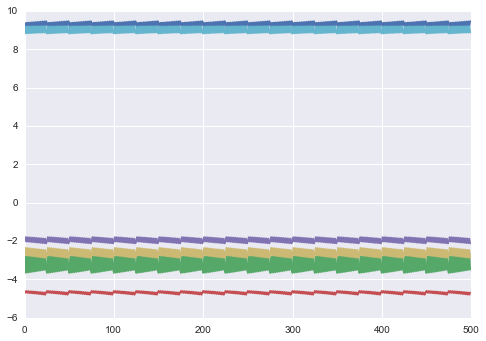

In [8]:
plot(test_output[3])

In [78]:
get_positions(test_output, 2)[:,1]

array([-1, -1,  0, ...,  0, -1, -1])

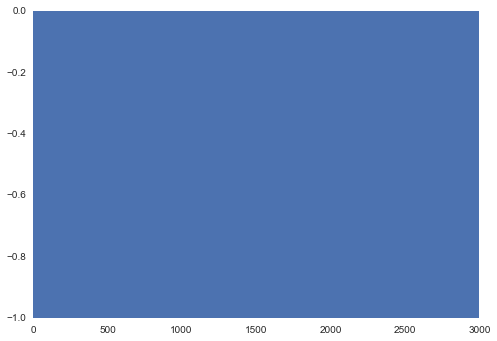

In [79]:
plot(get_positions(test_output, 2)[:,1])

In [80]:
pb_number = 2

def get_positions(output, ds):
    ordered = np.concatenate([x.reshape(-1, 25, pb_number*ds) for x in test_output], 1).reshape(-1,pb_number*ds)
    ls = []
    for i in range(ds):
        ls.append(np.argmax(ordered[:,i*pb_number:(i+1)*pb_number], 1)-1)
    return np.concatenate([x.reshape([-1,1]) for x in ls],1)
    #return np.argmax(np.concatenate(output), 1)-1
    #return np.argmax(np.concatenate([x.reshape(-1, 25, 3*2) for x in output], 1).reshape(-1,3*2), 1)-1

def get_target(targ):
    #return np.concatenate([(x.reshape(-1)) for x in test_targ])
    return np.concatenate(targ, 1).reshape(-1,2)

def get_equitycurve(pos, tar):
    ls = []
    ks = []
    for i in range(pos.shape[1]):
        rets = (pos*tar)[:,i]
        eq = np.cumprod((pos*tar)[:,i] + 1)
        ls.append(eq)
        ks.append(rets)
        plot(eq)
    show()
    plot(np.cumprod(np.sum(ks,0)+1))
    return 
        
    #return [np.cumprod((pos*tar)[:,i] + 1) for i in range(pos.shape[1])]

get_equitycurve(get_positions(test_output, 2), get_target(test_targ))

#plot(get_equitycurve(get_positions(test_output, 2), get_target(test_targ)))

ValueError: operands could not be broadcast together with shapes (3000,2) (2000,2) 

In [73]:
plot(eq[1])

NameError: name 'eq' is not defined

In [80]:
plot(pos[100:125])

NameError: name 'pos' is not defined

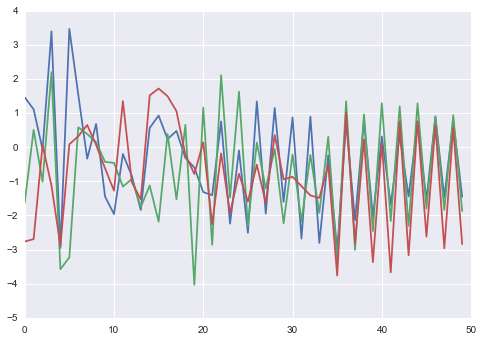

In [85]:
x=0
n = 6
plot(test_output[0][25:50].reshape(-1,3))

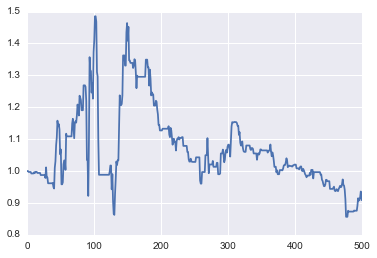

In [229]:
plot(np.cumprod((np.argmax(test_output[0],1)-1) * test_targ[0].reshape(-1)+1))

In [214]:
test_output[0].shape

(500, 3)

In [218]:
test_targ[0].reshape(-1)

array([ -2.59504002e-03,   3.88248474e-03,   2.96951691e-03,
        -7.44601479e-03,   1.69992819e-02,   1.69177400e-03,
         4.70721256e-03,   1.32415968e-03,  -4.01590280e-02,
         2.00323318e-03,  -3.64963547e-03,   2.90904660e-03,
        -4.37630061e-03,   1.27090258e-03,   1.45425892e-03,
        -3.45899235e-03,   3.80993495e-03,  -5.28141344e-03,
         1.28622735e-02,  -3.66948894e-04,   6.60424680e-03,
         4.61680628e-03,   1.05751613e-02,   1.51884034e-02,
        -1.54226488e-02,   1.00798355e-02,  -2.50318591e-02,
         9.31291468e-03,   3.40505913e-02,   3.13581303e-02,
         2.90240673e-03,   1.85849052e-02,   3.35386321e-02,
        -5.90179348e-03,   3.98970395e-03,   1.46088153e-02,
         1.41081400e-02,  -3.39558572e-02,  -1.40747463e-03,
         1.35862939e-02,   4.98695113e-03,   6.89071193e-02,
         2.02545281e-02,   4.85024862e-02,   2.28412598e-02,
         4.76054214e-02,   1.52649088e-02,  -6.07902650e-03,
        -1.41994311e-02,

In [217]:
test_targ[0][0]

array([[-0.00259504],
       [ 0.00388248],
       [ 0.00296952],
       [-0.00744601],
       [ 0.01699928],
       [ 0.00169177],
       [ 0.00470721],
       [ 0.00132416],
       [-0.04015903],
       [ 0.00200323],
       [-0.00364964],
       [ 0.00290905],
       [-0.0043763 ],
       [ 0.0012709 ],
       [ 0.00145426],
       [-0.00345899],
       [ 0.00380993],
       [-0.00528141],
       [ 0.01286227],
       [-0.00036695],
       [ 0.00660425],
       [ 0.00461681],
       [ 0.01057516],
       [ 0.0151884 ],
       [-0.01542265]], dtype=float32)

In [206]:
test_targ[0][0].reshape(-1)

array([-0.00259504,  0.00388248,  0.00296952, -0.00744601,  0.01699928,
        0.00169177,  0.00470721,  0.00132416, -0.04015903,  0.00200323,
       -0.00364964,  0.00290905, -0.0043763 ,  0.0012709 ,  0.00145426,
       -0.00345899,  0.00380993, -0.00528141,  0.01286227, -0.00036695,
        0.00660425,  0.00461681,  0.01057516,  0.0151884 , -0.01542265], dtype=float32)

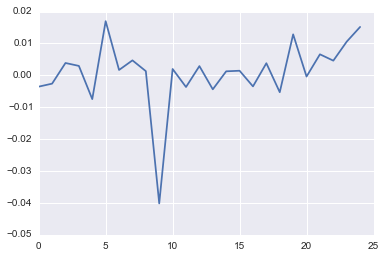

In [137]:
plot(test_inp[0][0])

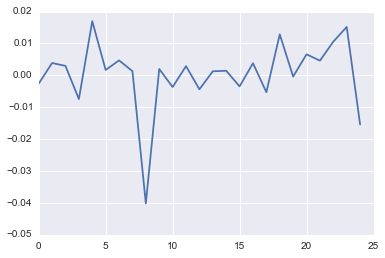

In [138]:
plot(test_targ[0][0])

In [167]:
test_output[0][:25,]

array([[-0.50313473, -9.14566231,  0.35615453],
       [-0.37630498, -7.11112261, -0.70588076],
       [-0.37363619, -7.10911226, -0.7056942 ],
       [-0.37376261, -7.10809135, -0.70627677],
       [-0.37625742, -7.13504505, -0.69292498],
       [-0.37384361, -7.10783291, -0.70645559],
       [-0.37367171, -7.107337  , -0.7067076 ],
       [-0.3738786 , -7.10826683, -0.70620131],
       [-0.3762539 , -7.13502169, -0.69293654],
       [-0.37384126, -7.10775185, -0.70650387],
       [-0.37365335, -7.1073513 , -0.70669627],
       [-0.37384212, -7.10807276, -0.70630753],
       [-0.37625468, -7.13503265, -0.69293034],
       [-0.37382513, -7.10767174, -0.70654678],
       [-0.37368315, -7.1073904 , -0.70667815],
       [-0.37379837, -7.10780811, -0.70645642],
       [-0.37611288, -7.13384342, -0.69351137],
       [-0.3738367 , -7.10773849, -0.70650995],
       [-0.3736918 , -7.10737848, -0.70668697],
       [-0.37380508, -7.10784388, -0.70643675],
       [-0.37624282, -7.13494444, -0.692

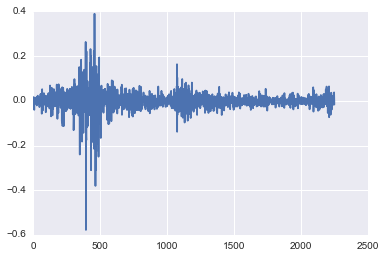

In [119]:
plot(rets)

In [41]:
inv = test_output[0][25*x*1:25*1*(x+1)].reshape(-1,6)

In [235]:
test_output[0][0:25*6].reshape(-1,6).shape

(150, 6)

In [256]:
np.mul(inv[:,:])

AttributeError: 'module' object has no attribute 'mul'

In [42]:
np.sum(inv,1)

array([ -6.98216486,  -6.98215246,  -6.98232746,  -6.98221302,
        -6.98204231,  -6.98219585,  -6.98207426,  -6.98217106,
        -6.98215723,  -6.98219633,  -6.98216343,  -6.98217678,
        -6.98221302,  -6.98215961,  -6.98213148,  -6.9821701 ,
        -6.98215151,  -6.98215818,  -6.98216295,  -6.98211956,
       -14.57940769, -14.57942486, -14.57956505, -14.57947636, -14.57931995], dtype=float32)